<a href="https://colab.research.google.com/github/SriNithin965/project-4-2/blob/main/code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PACKAGES INSTALLING

In [1]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.7 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


PACKAGES LOADING

In [2]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

DATA LOADING

In [30]:
data = pd.read_excel('https://github.com/SriNithin965/project-4-2/raw/main/data/Sample-Superstore.xls')

DATA TRANSFORMATION

In [31]:
data1 = data[['Ship Date','Sales']]
data1 = data1.groupby('Ship Date').sum()
data1 = data1.resample('MS').median()
data1.head(10)

,Sales
Ship Date,
2014-01-01,149.950
2014-02-01,112.411
2014-03-01,483.546
2014-04-01,680.252
2014-05-01,504.828
2014-06-01,656.066
2014-07-01,504.586
2014-08-01,884.666
2014-09-01,947.648


In [32]:
data1 = data1.dropna()

In [33]:
data1 = data1.reset_index()

In [34]:
data1.rename(columns={'Ship Date':'date','Sales':'sales'},inplace=True)

In [35]:
df_diff = data1.copy()
df_diff['prev_sales'] = df_diff['sales'].shift(1)
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,prev_sales,diff
1,2014-02-01,112.4110,149.950,-37.5390
2,2014-03-01,483.5460,112.411,371.1350
3,2014-04-01,680.2520,483.546,196.7060
4,2014-05-01,504.8280,680.252,-175.4240
5,2014-06-01,656.0660,504.828,151.2380
6,2014-07-01,504.5860,656.066,-151.4800
7,2014-08-01,884.6660,504.586,380.0800
8,2014-09-01,947.6480,884.666,62.9820
9,2014-10-01,672.9930,947.648,-274.6550
10,2014-11-01,2202.8545,672.993,1529.8615


ADDING THE LAGS

In [36]:
df_supervised = df_diff.drop(['prev_sales'],axis=1)
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [11]:
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-01-25,38.660,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110,-30.604,-66.150,-4268.186,4067.380,278.272
1,2014-01-26,2635.210,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110,-30.604,-66.150,-4268.186,4067.380
2,2014-01-27,5.940,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110,-30.604,-66.150,-4268.186
3,2014-01-28,40.080,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110,-30.604,-66.150
4,2014-01-29,152.640,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110,-30.604
5,2014-01-31,944.610,791.970,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110,1394.110
6,2014-02-02,717.336,-227.274,791.970,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990,-858.110
7,2014-02-03,472.828,-244.508,-227.274,791.970,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609,-395.990
8,2014-02-04,240.500,-232.328,-244.508,-227.274,791.970,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965,1870.609
9,2014-02-06,109.462,-131.038,-232.328,-244.508,-227.274,791.970,112.560,34.140,-2629.270,2596.550,13.412,-39.616,-313.730,-1641.965


In [37]:
len(df_supervised)

36

In [38]:
df_model = df_supervised.drop(['date','sales'],axis=1)
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

MAKING USE OF MIN MAX SCALER

In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [40]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

LSTM BUILDING AND TRAINING

In [41]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
30/30 [==============================] - 2s 2ms/step - loss: 0.1702
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1624
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1573
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1528
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1486
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1447
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1409
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1372
Epoch 9/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1336
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1300
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1264
Epoch 12/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1228
Epoch 13/100
30/30 [=================

PREDICT

In [42]:
y_pred = model.predict(X_test,batch_size=1)
y_pred

array([[ 0.03235635],
       [ 0.6483784 ],
       [-0.88973725],
       [ 0.4425379 ],
       [ 1.0209774 ],
       [-0.6884754 ]], dtype=float32)

ERROR CALCULATION

In [43]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                   # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
             'minmax':minmax})
forecast_accuracy(y_pred,y_test)

{'mae': 0.2806108488964593,
 'mape': 0.5588494213310115,
 'me': -0.011484961670662005,
 'minmax': 0.22699336032397888,
 'mpe': 0.025171381989672215,
 'rmse': 0.3217844145850354}

DATA FRAME FORMATION

In [44]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ 0.03235635  0.15306959  0.0969      0.31223718  0.06080036  0.33473855
   0.20749561 -1.49691772  0.50156855  0.80504878 -1.17023556  0.73690758
  -0.26465099]]
[[ 0.64837837  0.3707856   0.15306959  0.0969      0.31223718  0.06080036
   0.33473855  0.01059088 -1.49691772  0.50156855  0.78845496 -1.17023556
   0.73690758]]
[[-0.88973725  0.85295326  0.3707856   0.15306959  0.0969      0.31223718
   0.06080036  0.16944845  0.01059088 -1.49691772  0.45914317  0.78845496
  -1.17023556]]
[[ 0.4425379  -0.68132225  0.85295326  0.3707856   0.15306959  0.0969
   0.31223718 -0.1725521   0.16944845  0.01059088 -1.70944981  0.45914317
   0.78845496]]
[[ 1.02097738  0.5674062  -0.68132225  0.85295326  0.3707856   0.15306959
   0.0969      0.14135642 -0.1725521   0.16944845 -0.07362543 -1.70944981
   0.45914317]]
[[-0.68847537  0.41737886  0.5674062  -0.68132225  0.85295326  0.3707856
   0.15306959 -0.1274832   0.14135642 -0.1725521   0.09875375 -0.07362543
  -1.70944981]]


In [45]:
result_list = []
sales_dates = list(data1[-7:].date)
act_sales = list(data1[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [46]:
data2 = data1.copy()
df_re = df_result.copy()
data2  = data2.set_index('date')
df_re = df_re.set_index('date')

PLOTING

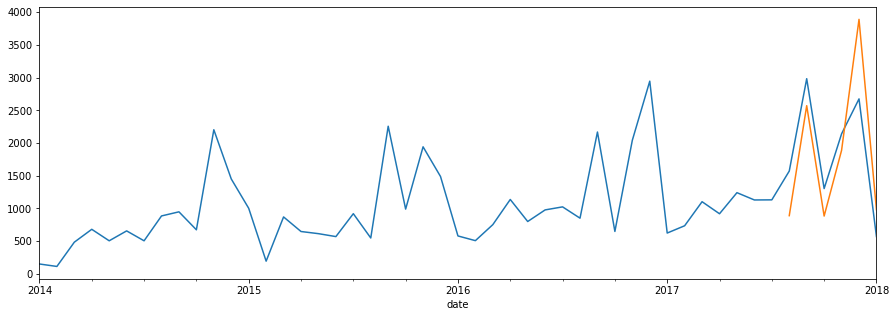

In [47]:
import matplotlib.pyplot as plt
data2['sales'].plot(figsize=(15,5))
df_re['pred_value'].plot()
plt.show()